In [1]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Allows plots to appear directly in the notebook.
%matplotlib inline

from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [2]:
import pandas as pd
df = pd.read_parquet('df_final_filtered.parquet')

print(df.shape)

(15600, 16)


In [3]:
import pandas as pd
df_onehot_raw = pd.read_parquet('df_final_filtered_onehot.parquet')

print(df_onehot_raw.shape)

(15600, 24)


In [4]:
df_onehot_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15600 entries, 0 to 15599
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   datetime                  15600 non-null  datetime64[ns]
 1   zone_id                   15600 non-null  int64         
 2   zone_name                 15600 non-null  object        
 3   mta_flow                  15600 non-null  float64       
 4   taxi_flow                 15600 non-null  float64       
 5   trip_distance             15600 non-null  float64       
 6   fare_amount               15600 non-null  float64       
 7   has_congestion_surcharge  15600 non-null  float64       
 8   temp                      15600 non-null  float64       
 9   prcp                      15600 non-null  float64       
 10  coco                      15600 non-null  float64       
 11  coco_group                15600 non-null  object        
 12  total_flow        

In [5]:
df_onehot = df_onehot_raw.copy()

In [6]:
df_onehot['datetime'] = pd.to_datetime(df_onehot['datetime'])
df_onehot['month'] = df_onehot['datetime'].dt.month

### 1. Base - Linear Regression (Mta + Taxi + Weather)

In [7]:
#Split the dataset into two datasets:
#Train Feb + Jun
#Test  Sep + Dec
train_df = df_onehot[df_onehot['month'].isin([2,6])]
test_df = df_onehot[df_onehot['month'].isin([9,12])]

print("Train size: ", len(train_df))
print("Test size: ", len(test_df))

Train size:  7670
Test size:  7930


In [8]:
df2 = train_df.copy()

#### Observation

##### 1-1 continuous_features

In [9]:
#corr in continuous_features
continuous_features = [
    'mta_flow',
    'taxi_flow',
    'trip_distance',
    'fare_amount',
    'temp',
    'prcp',
    'total_flow',  # target column
    'hour',
    'month'
]

In [10]:
!pip install seaborn

In [11]:
corr_df = df_onehot[continuous_features]

corr = corr_df.corr()

target_corr = corr['total_flow'].drop('total_flow').sort_values(ascending=False)
print(target_corr)

mta_flow         0.999453
taxi_flow        0.653387
hour             0.385971
temp             0.082147
month            0.049328
fare_amount      0.010652
trip_distance   -0.004297
prcp            -0.023804
Name: total_flow, dtype: float64


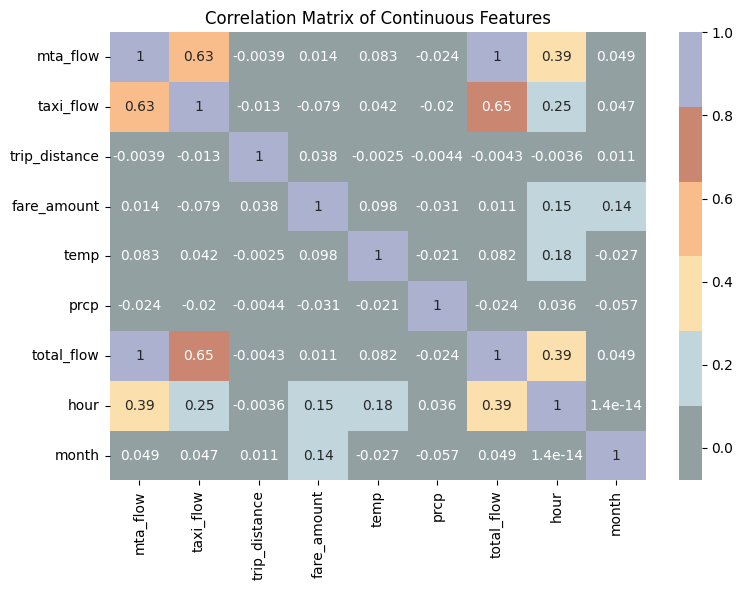

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_onehot[continuous_features].corr()

# heatmap
plt.figure(figsize=(8, 6))
custom_cmap = sns.color_palette(["#92a0a1", "#c1d6dc", "#fbe0ae", "#f8bd8b", "#ca8671","#abb1cf"], as_cmap=True)
sns.heatmap(corr, annot=True, cmap=custom_cmap)
plt.title("Correlation Matrix of Continuous Features")
plt.tight_layout()
plt.show()

In [13]:
#transform 'hour' and 'month' into one-hot encoding
df_onehot_h = pd.get_dummies(df, columns=['hour'], prefix='hour')
df_onehot_d = pd.get_dummies(df, columns=['weekday'], prefix='day')

In [14]:
df_onehot_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15600 entries, 0 to 15599
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   datetime                  15600 non-null  datetime64[ns]
 1   zone_id                   15600 non-null  int64         
 2   zone_name                 15600 non-null  object        
 3   mta_flow                  15600 non-null  float64       
 4   taxi_flow                 15600 non-null  float64       
 5   trip_distance             15600 non-null  float64       
 6   fare_amount               15600 non-null  float64       
 7   has_congestion_surcharge  15600 non-null  float64       
 8   temp                      15600 non-null  float64       
 9   prcp                      15600 non-null  float64       
 10  coco                      15600 non-null  float64       
 11  coco_group                15392 non-null  object        
 12  total_flow        

In [15]:
continuous_features_h = [
    'mta_flow',
    'taxi_flow',
    'trip_distance',
    'fare_amount',
    'has_congestion_surcharge',
    'temp',
    'prcp',
    'total_flow'
] + [col for col in df_onehot_h.columns if col.startswith('hour_')]


In [16]:
continuous_features_d = [
    'mta_flow',
    'taxi_flow',
    'trip_distance',
    'fare_amount',
    'has_congestion_surcharge',
    'temp',
    'prcp',
    'total_flow'
] + [col for col in df_onehot_d.columns if col.startswith('day_')]

In [17]:
corr_df_h = df_onehot_h[continuous_features_h]

corr = corr_df_h.corr()

target_corr = corr['total_flow'].drop('total_flow').sort_values(ascending=False)
print(target_corr)

mta_flow                    0.999453
taxi_flow                   0.653387
hour_17                     0.268002
hour_16                     0.152315
hour_18                     0.135335
temp                        0.082147
hour_15                     0.073411
has_congestion_surcharge    0.021096
fare_amount                 0.010652
trip_distance              -0.004297
hour_14                    -0.017618
prcp                       -0.023804
hour_13                    -0.077810
hour_12                    -0.109264
hour_9                     -0.120711
hour_11                    -0.142529
hour_10                    -0.161132
Name: total_flow, dtype: float64


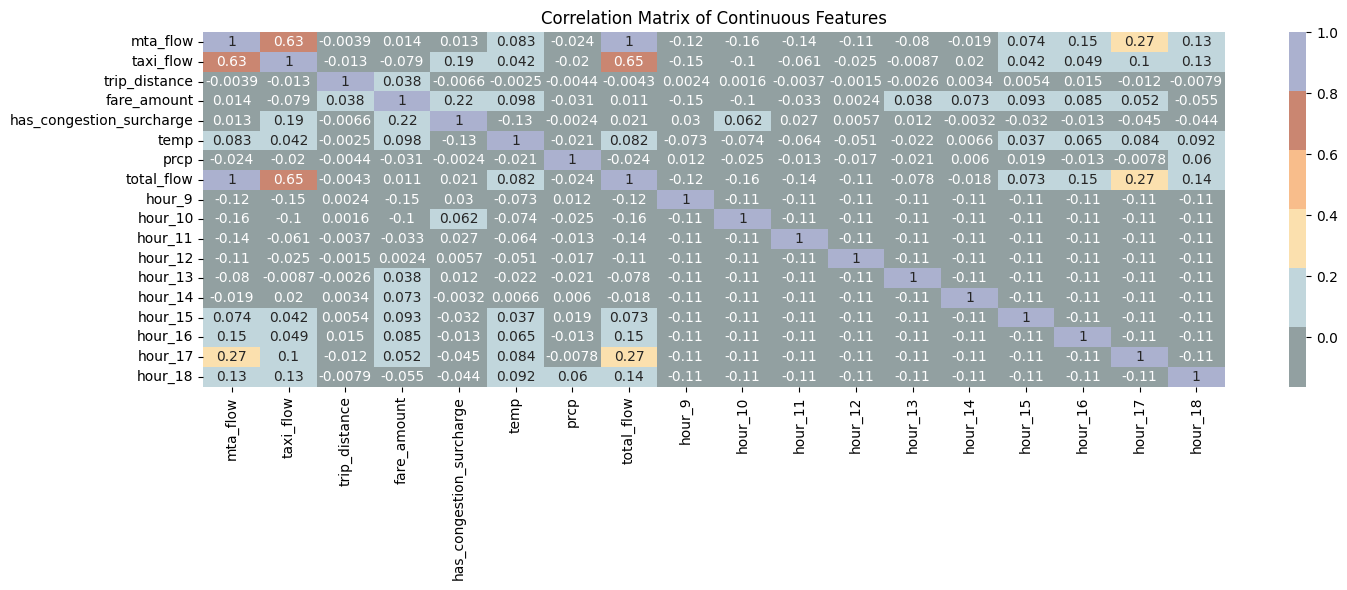

In [18]:
corr_matrix_h = df_onehot_h[continuous_features_h].corr()

# heatmap
plt.figure(figsize=(15, 6))
custom_cmap = sns.color_palette(["#92a0a1", "#c1d6dc", "#fbe0ae", "#f8bd8b", "#ca8671","#abb1cf"], as_cmap=True)
sns.heatmap(corr, annot=True, cmap=custom_cmap)
plt.title("Correlation Matrix of Continuous Features")
plt.tight_layout()
plt.show()

`Hourly` Impact on Total Flow
1. Peak Hours (Positive Correlation)
The time slots between 3:00 PM and 6:00 PM (hour_15 to hour_18) show a positive correlation with total_flow, particularly:

- 5:00 PM (hour_17) shows the strongest positive relationship (+0.268), indicating it is the core of the evening rush hour.

- 4:00 PM (hour_16) and 6:00 PM (hour_18) also contribute significantly (+0.15 ~ +0.13), forming a clear upward trend in traffic.

Interpretation:
This confirms that the late afternoon to early evening is the busiest period, likely due to workday commuting patterns.

2. Off-Peak Hours (Negative Correlation)
- Several time slots between 9:00 AM and 1:00 PM (hour_9 to hour_13) show a negative correlation with total flow:

- 10:00 AM (hour_10) has the lowest correlation (–0.161), marking it as the quietest period.

- Other hours like hour_11, hour_12, and hour_9 also show modest negative values (–0.12 ~ –0.14).

Interpretation:
These hours reflect the lull after the morning commute and before the afternoon buildup—typical mid-day low traffic periods.


Consider assigning higher weights to `hour_17, hour_16, and hour_18`, and lower or zero weights to late morning hours.

In [19]:
corr_df_d = df_onehot_d[continuous_features_d]

corr = corr_df_d.corr()

target_corr = corr['total_flow'].drop('total_flow').sort_values(ascending=False)
print(target_corr)

mta_flow                    0.999453
taxi_flow                   0.653387
day_3                       0.085889
temp                        0.082147
day_2                       0.067727
day_1                       0.060680
day_4                       0.034191
has_congestion_surcharge    0.021096
day_0                       0.013017
fare_amount                 0.010652
trip_distance              -0.004297
prcp                       -0.023804
day_5                      -0.089105
day_6                      -0.162529
Name: total_flow, dtype: float64


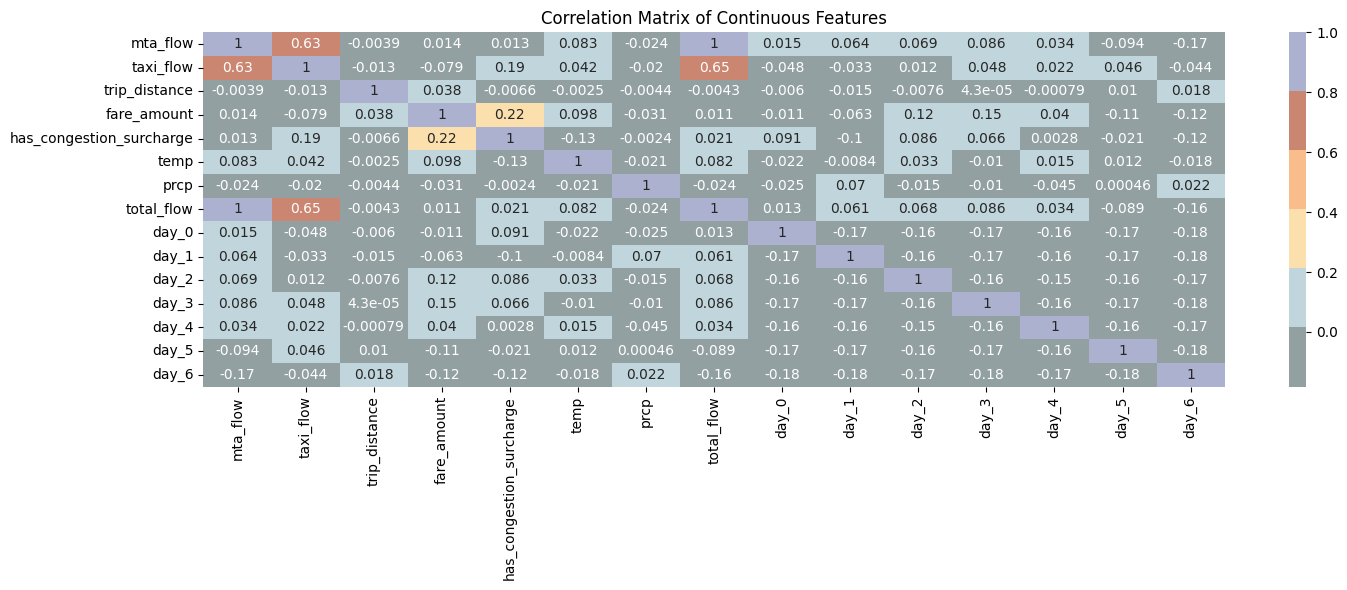

In [20]:
corr_matrix_d = df_onehot_d[continuous_features_d].corr()

# heatmap
plt.figure(figsize=(15, 6))
custom_cmap = sns.color_palette(["#92a0a1", "#c1d6dc", "#fbe0ae", "#f8bd8b", "#ca8671","#abb1cf"], as_cmap=True)
sns.heatmap(corr, annot=True, cmap=custom_cmap)
plt.title("Correlation Matrix of Continuous Features")
plt.tight_layout()
plt.show()

`Week day` Impact on Total Flow
 Interpretation:
Weekdays (Tuesday to Thursday) show the strongest positive correlation with total flow. These are likely dominated by routine commuting behavior.

- Monday shows a neutral correlation, possibly due to slower start-of-week routines.

- Friday shows a small positive correlation, indicating a slight drop-off compared to midweek.

- Weekends (Saturday and Sunday) have negative correlations, especially Sunday, which indicates a noticeable drop in overall transportation activity captured in this dataset.

Weight formula construction	Consider assigning `higher weights to day_1–day_3 (Tue–Thu)`, `lower weights to day_5–day_6 (Sat–Sun)`.

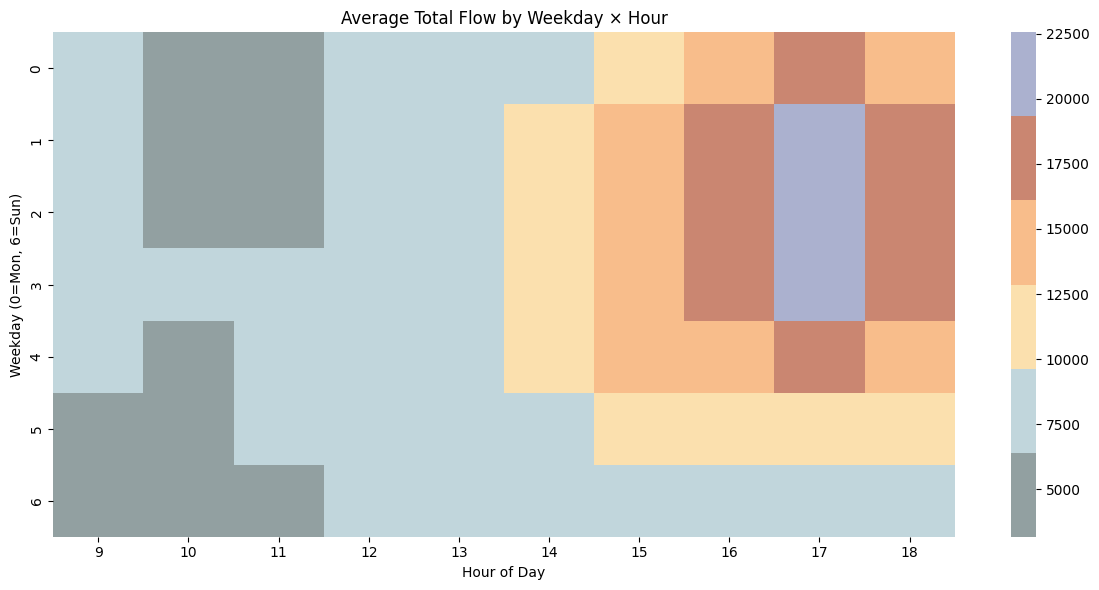

In [21]:
# hour + day
df['avg_flow'] = df['total_flow']
pivot_table = df.groupby(['weekday', 'hour'])['avg_flow'].mean().unstack()


plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap=custom_cmap, annot=False)
plt.title('Average Total Flow by Weekday × Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Weekday (0=Mon, 6=Sun)')
plt.tight_layout()
plt.show()

 Interpretation: `Weekday × Hour` vs `Total Flow`
1. High Traffic Hotspots:
- Weekdays (Tuesday to Thursday, i.e., weekday 1–3)

- Clear peaks during 4PM–6PM (hour 16–18).

- Hour 17 on Tuesday/Wednesday/Thursday shows the highest intensity — visible via the darkest color (deep purple → ~22,500 flow).

This confirms a strong and consistent evening commute pattern on working days.

2. Low Traffic Zones:
- Weekend (weekday 5 = Saturday, 6 = Sunday)

- Overall flow is significantly lower and flatter across all hours.

There’s a mild rise during afternoon hours (hour 14–15), but nothing like weekday peaks.

3. Transitional Patterns:
- Monday (weekday 0) and Friday (weekday 4)

- Show partial peaks, less intense than Tue–Thu.

- Monday starts slowly; Friday has potential early departures or flexibility.

##### 1-2 categorical_features

In [22]:
df_onehot_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15600 entries, 0 to 15599
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   datetime                  15600 non-null  datetime64[ns]
 1   zone_id                   15600 non-null  int64         
 2   zone_name                 15600 non-null  object        
 3   mta_flow                  15600 non-null  float64       
 4   taxi_flow                 15600 non-null  float64       
 5   trip_distance             15600 non-null  float64       
 6   fare_amount               15600 non-null  float64       
 7   has_congestion_surcharge  15600 non-null  float64       
 8   temp                      15600 non-null  float64       
 9   prcp                      15600 non-null  float64       
 10  coco                      15600 non-null  float64       
 11  coco_group                15600 non-null  object        
 12  total_flow        

In [23]:
categorical_features = [
    'mta_flow',
    'taxi_flow',
    'trip_distance',
    'fare_amount',
    'has_congestion_surcharge',
    'temp',
    'prcp',
    'coco',
    'coco_group',
    'total_flow'
] + [col for col in df_onehot_raw.columns if col.startswith('weather_')]

Correlation with total_flow:
mta_flow                    0.999453
taxi_flow                   0.653387
temp                        0.082147
weather_Unknown             0.046838
has_congestion_surcharge    0.021096
weather_Cloudy/Overcast     0.018409
fare_amount                 0.010652
weather_Heavy Rain          0.005895
weather_Rain                0.005435
trip_distance              -0.004297
weather_Clear/Fair         -0.004370
prcp                       -0.023804
weather_Snow/Sleet         -0.024347
weather_Fog/Low-Vis        -0.034969
weather_Heavy Snow/Sleet   -0.040170
Name: total_flow, dtype: float64
weather_effect: 
                    Weather  Average_Total_Flow
7           weather_Unknown        13656.336538
3        weather_Heavy Rain        10502.542986
5              weather_Rain        10266.590533
1   weather_Cloudy/Overcast        10261.315996
0        weather_Clear/Fair        10019.831474
2       weather_Fog/Low-Vis         8728.382134
6        weather_Snow/Sleet   

C:\Users\mm921\AppData\Local\Temp\ipykernel_17232\1802052477.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_weather_effect, x='Average_Total_Flow', y='Weather', palette='coolwarm')


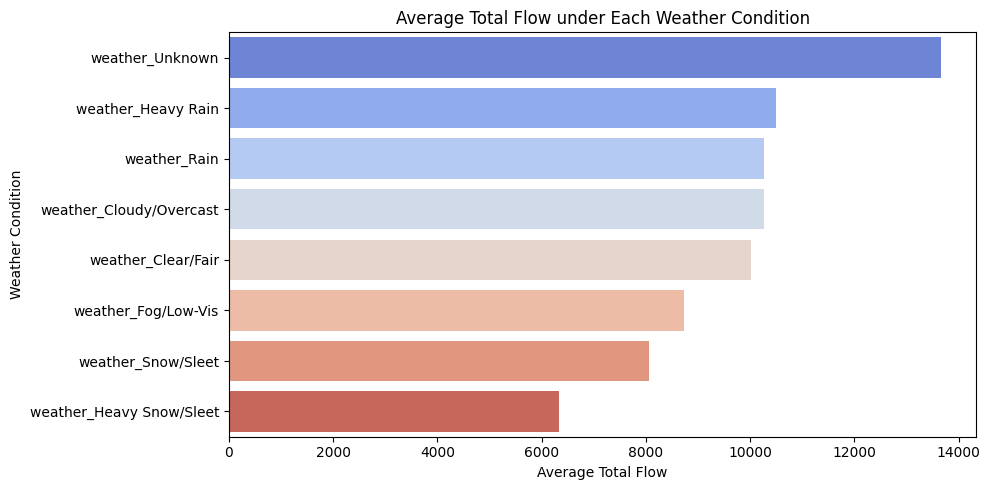

In [24]:
weather_cols = [col for col in df_onehot_raw.columns if col.startswith('weather_')]

categorical_features = [
    'mta_flow', 'taxi_flow', 'trip_distance', 'fare_amount',
    'has_congestion_surcharge', 'temp', 'prcp', 'total_flow'
] + weather_cols

corr_df_w = df_onehot_raw[categorical_features]
corr = corr_df_w.corr()
target_corr = corr['total_flow'].drop('total_flow').sort_values(ascending=False)
print("Correlation with total_flow:")
print(target_corr)

weather_means = {
    col: df_onehot_raw[df_onehot_raw[col] == 1]['total_flow'].mean()
    for col in weather_cols
}

df_weather_effect = pd.DataFrame({
    'Weather': list(weather_means.keys()),
    'Average_Total_Flow': list(weather_means.values())
}).sort_values(by='Average_Total_Flow', ascending=False)

print("weather_effect: ")
print(df_weather_effect)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_weather_effect, x='Average_Total_Flow', y='Weather', palette='coolwarm')
plt.title("Average Total Flow under Each Weather Condition")
plt.xlabel("Average Total Flow")
plt.ylabel("Weather Condition")
plt.tight_layout()
plt.show()

 Interpretation: `Weather` vs `Total Flow`

- Weather_Unknown surprisingly shows the highest flow. This may reflect:

Sensor errors or unrecorded values during non-disruptive conditions

- Data anomalies or default values

- Moderate weather (Rain, Cloudy, Clear) results in mid-to-high flow, indicating people continue to commute even under light rain or overcast skies.

- Severe weather, especially Heavy Snow/Sleet, corresponds to the lowest flow, aligning with expectations of reduced mobility and potential disruptions.

C:\Users\mm921\AppData\Local\Temp\ipykernel_17232\1508421791.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\mm921\AppData\Local\Temp\ipykernel_17232\1508421791.py:12: UserWarning: 
The palette list has fewer values (6) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


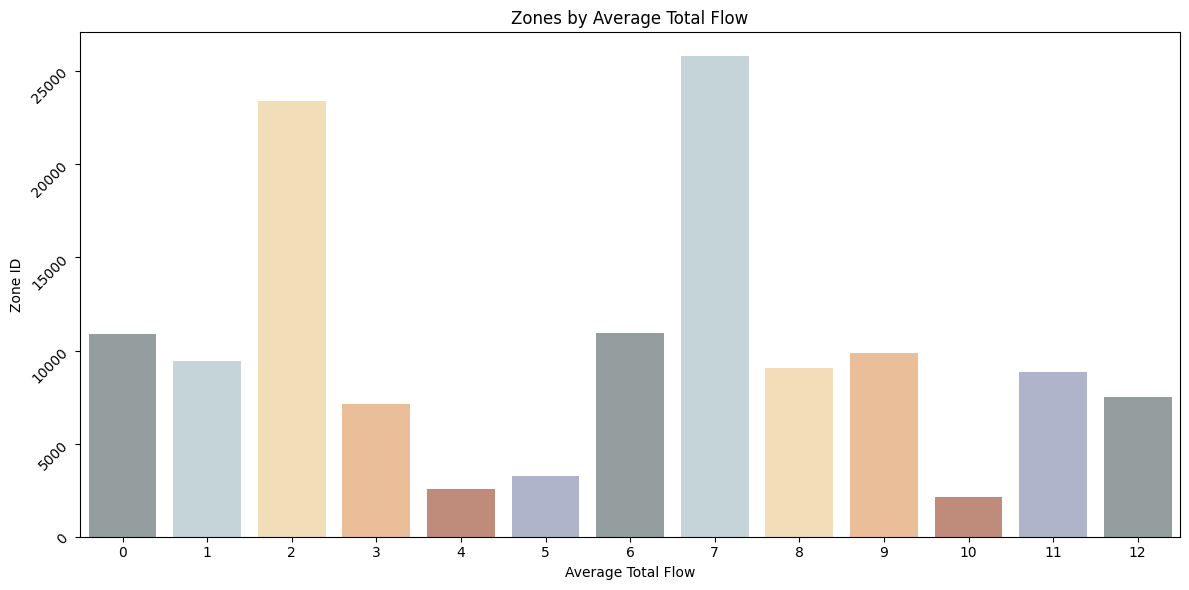

In [25]:
# zone
zone_avg = df.groupby('zone_id')['total_flow'].mean().sort_values(ascending=False)

df_zone_effect = pd.DataFrame({
    'Zone_ID': zone_avg.index,
    'Average_Total_Flow': zone_avg.values
}).reset_index(drop=True)  # 避免多餘 index 欄位

df_zone_effect['Zone_ID'] = df_zone_effect['Zone_ID'].astype(int)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_zone_effect.sort_values('Average_Total_Flow', ascending=False).head(13),
    x='Zone_ID',
    y='Average_Total_Flow',
    
    palette=custom_cmap
)
plt.title("Zones by Average Total Flow")
plt.xlabel("Average Total Flow")
plt.ylabel("Zone ID")

plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
# zone + hour + weekday
#groupby

df_onehot['avg_flow'] = df_onehot['total_flow']
zone_hour_day = df_onehot.groupby(['zone_id','hour', 'weekday'])['avg_flow'].mean().reset_index()

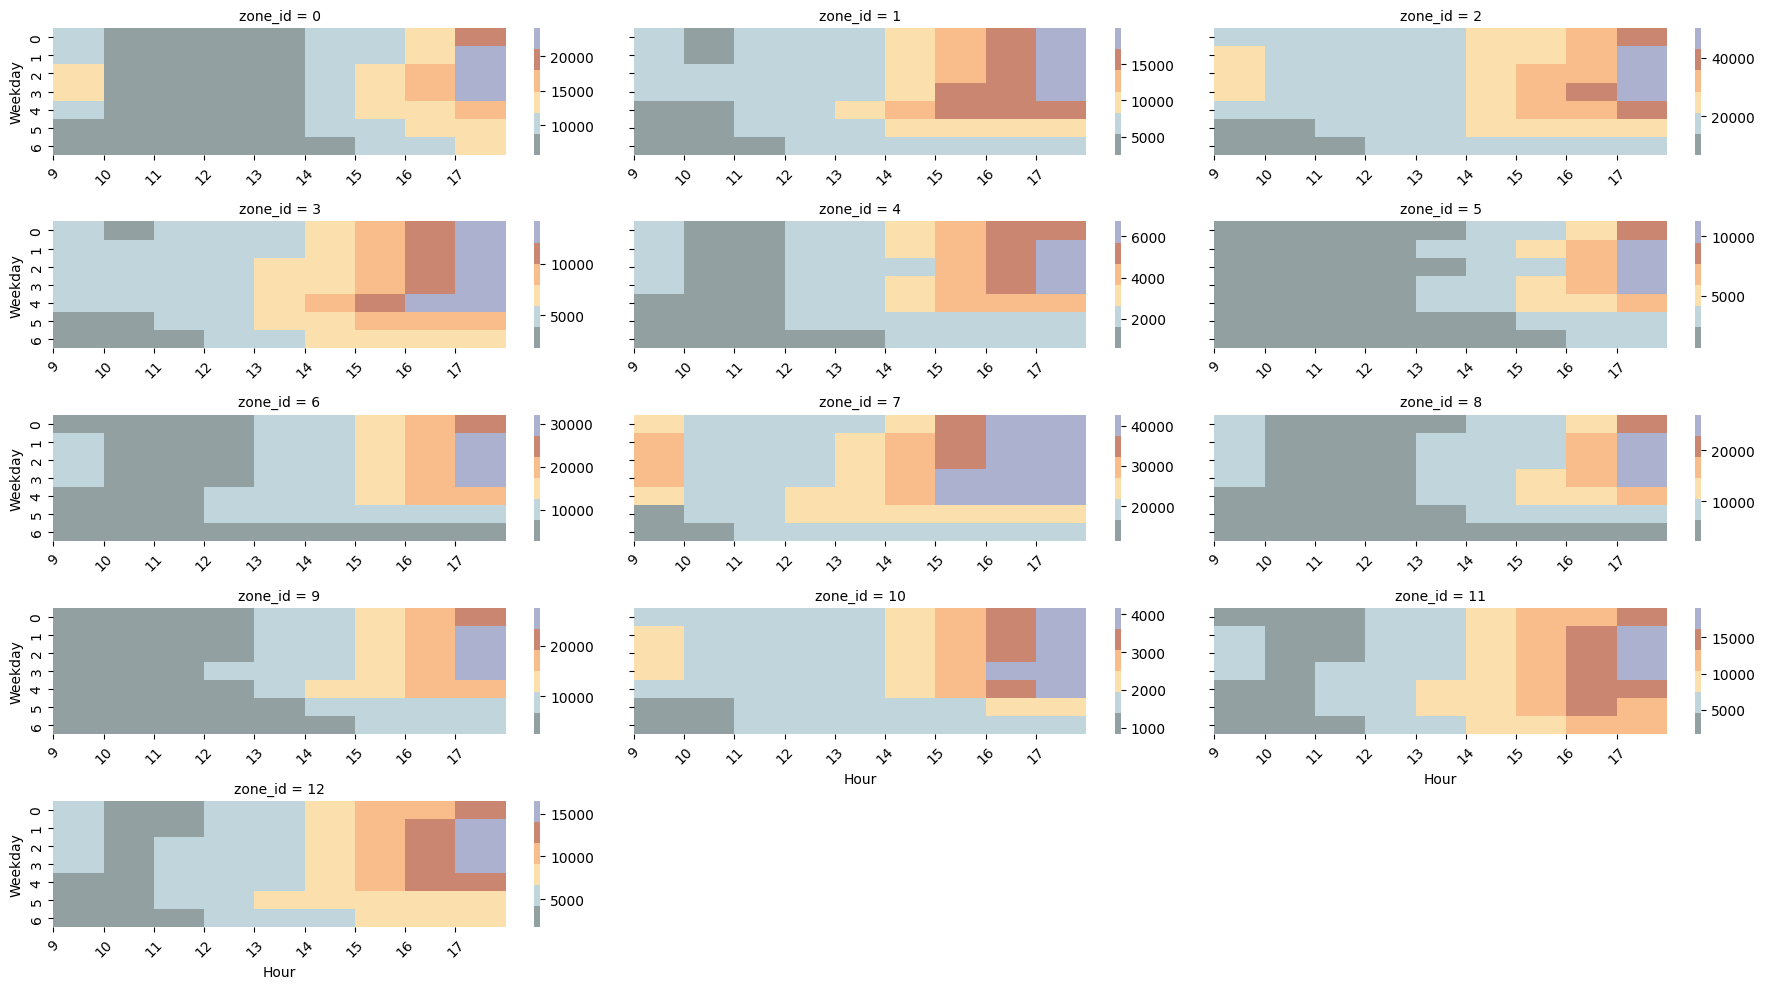

In [27]:
#draw heatmap of every zone
import numpy as np

zone_hour_day['zone_id'] = zone_hour_day['zone_id'].astype(str)
all_hours = np.arange(9, 18)

g = sns.FacetGrid(zone_hour_day, col="zone_id", col_wrap=3, height=10)

#x-axis --> hour(0-23), y-axis --> weekday(0-6), each block --> avg_flow
g.map_dataframe(
    lambda data, color: sns.heatmap(
        data.pivot(index='weekday', columns = 'hour', values = 'avg_flow')
            .reindex(columns=all_hours),
        cmap=custom_cmap, cbar=True, xticklabels=True, yticklabels=True
    )
)

# g.set_titles(col_template="Zone {zone_name}")
g.set_axis_labels("Hour", "Weekday")

for ax in g.axes.flat:
    ax.set_xticks(np.arange(len(all_hours)))
    ax.set_xticklabels(all_hours, rotation=45)
    ax.tick_params(axis='x', labelbottom=True)
    
plt.subplots_adjust(bottom=0.15)
g.fig.set_size_inches(18,10)

plt.tight_layout()
plt.show()

In [28]:
zone_hour_day = (
    df.groupby(['zone_id', 'weekday', 'hour'])['total_flow']
    .mean()
    .reset_index(name='avg_flow')
)

# 確保型別一致
zone_hour_day['zone_id'] = zone_hour_day['zone_id'].astype(int)
zone_hour_day['weekday'] = zone_hour_day['weekday'].astype(int)
zone_hour_day['hour'] = zone_hour_day['hour'].astype(int)

# 建立所有可能組合
zones = zone_hour_day['zone_id'].unique()
weekdays = np.arange(0, 7)
hours = np.arange(9, 18)

full_index = pd.MultiIndex.from_product([zones, weekdays, hours],
                                        names=['zone_id', 'weekday', 'hour'])
full_df = pd.DataFrame(index=full_index).reset_index()

# 🔧 加這一行！
full_df['zone_id'] = full_df['zone_id'].astype(int)

# 合併
df_3d = pd.merge(full_df, zone_hour_day, on=['zone_id', 'weekday', 'hour'], how='left')

display(df_3d.head(20))

,zone_id,weekday,hour,avg_flow
0,0,0,9,10093.222222
1,0,0,10,7780.555556
2,0,0,11,7308.944444
3,0,0,12,7131.722222
4,0,0,13,7774.166667
5,0,0,14,9185.388889
6,0,0,15,10840.777778
7,0,0,16,13576.666667
8,0,0,17,19154.055556
9,0,1,9,11763.647059


In [29]:
df_3d.to_csv("zone_hour_weekday_avgflow.csv", index=False)

<mark>Observation</mark>

Zone 0:
  - Peak flow: 24039 at weekday 2, hour 17
  - Off-peak flow: 5744 at weekday 6, hour 9

Zone 1:
  - Peak flow: 19974 at weekday 3, hour 17
  - Off-peak flow: 2490 at weekday 6, hour 9

Zone 2:
  - Peak flow: 50167 at weekday 3, hour 17
  - Off-peak flow: 6763 at weekday 6, hour 9

Zone 3:
  - Peak flow: 14085 at weekday 3, hour 17
  - Off-peak flow: 1809 at weekday 6, hour 9

Zone 4:
  - Peak flow: 6726 at weekday 3, hour 17
  - Off-peak flow: 590 at weekday 6, hour 9

Zone 5:
  - Peak flow: 11223 at weekday 3, hour 17
  - Off-peak flow: 622 at weekday 6, hour 9

Zone 6:
  - Peak flow: 32193 at weekday 2, hour 17
  - Off-peak flow: 2697 at weekday 6, hour 9

Zone 7:
  - Peak flow: 42727 at weekday 3, hour 17
  - Off-peak flow: 11374 at weekday 6, hour 9

Zone 8:
  - Peak flow: 26933 at weekday 1, hour 17
  - Off-peak flow: 2292 at weekday 6, hour 9

Zone 9:
  - Peak flow: 27501 at weekday 2, hour 17
  - Off-peak flow: 2575 at weekday 6, hour 9

Zone 10:
  - Peak flow: 4179 at weekday 3, hour 17
  - Off-peak flow: 825 at weekday 6, hour 9

Zone 11:
  - Peak flow: 19104 at weekday 3, hour 17
  - Off-peak flow: 1667 at weekday 6, hour 9

Zone 12:
  - Peak flow: 16480 at weekday 3, hour 17
  - Off-peak flow: 1714 at weekday 6, hour 9

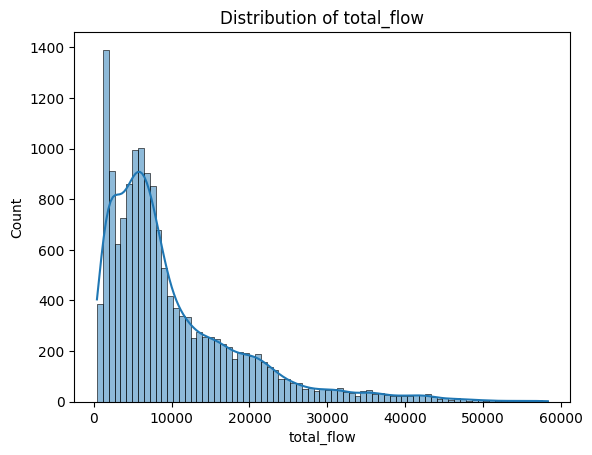

In [30]:
#check target distribution
sns.histplot(df['total_flow'], kde=True)
plt.title("Distribution of total_flow")
plt.show()

In [31]:
# log_transformation for linear Regression
df2['log_total_flow'] = np.log1p(df2['total_flow'])  # log(1 + x)，可避免 log(0)

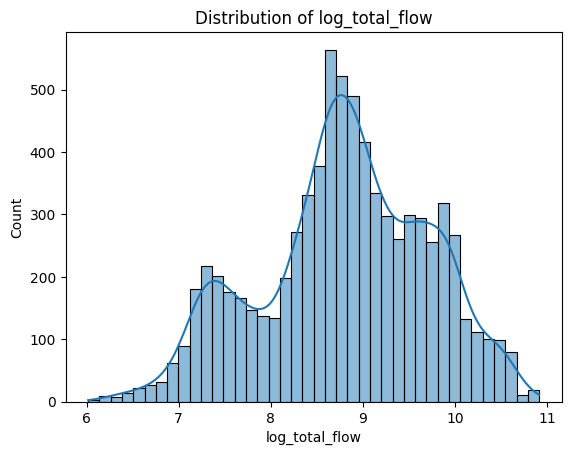

In [32]:
#check target distribution
sns.histplot(df2['log_total_flow'], kde=True)
plt.title("Distribution of log_total_flow")
plt.show()

In [33]:
#模型預測完 還原預測值
# y_pred_original = np.expm1(y_pred_log)

#### 2-1 continuous features

In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7670 entries, 0 to 7669
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   datetime                  7670 non-null   datetime64[ns]
 1   zone_id                   7670 non-null   int64         
 2   zone_name                 7670 non-null   object        
 3   mta_flow                  7670 non-null   float64       
 4   taxi_flow                 7670 non-null   float64       
 5   trip_distance             7670 non-null   float64       
 6   fare_amount               7670 non-null   float64       
 7   has_congestion_surcharge  7670 non-null   float64       
 8   temp                      7670 non-null   float64       
 9   prcp                      7670 non-null   float64       
 10  coco                      7670 non-null   float64       
 11  coco_group                7670 non-null   object        
 12  total_flow               

##### 2-1-1 simple linear regression

 #Todo
 - mta_flow
 - taxi_flow
 - fare_amount
 - surcharge
 - weather (temp, prcp, condition)
 - time (hour_*, weekday_*)
 - zone_id

In [35]:
df3 = df2.copy()

In [36]:
continuous_features = [
    'mta_flow', 'taxi_flow',
    'fare_amount', 'has_congestion_surcharge',
    'temp', 'prcp'
]
# categorical_features = [col for col in df3.columns if col.startswith('hour_') or 
#                         col.startswith('weekday_') or 
#                         col.startswith('condition_') or 
#                         col.startswith('zone_')]

In [37]:
# Prepare the descriptive features

X_cat = df3[continuous_features]
y = df3['log_total_flow']

print("\nDescriptive features in X:\n", X_cat)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
       mta_flow  taxi_flow  fare_amount  has_congestion_surcharge  temp  prcp
0      10721.0      410.0    20.602242                  0.964321   3.3   0.0
1       6384.0      730.0    19.515128                  0.954242   3.3   0.0
2      24019.0      670.0    17.372795                  0.964281   3.3   0.0
3       4454.0        7.0    24.001667                  0.833333   3.3   0.0
4       2072.0        3.0    40.266667                  1.000000   3.3   0.0
...        ...        ...          ...                       ...   ...   ...
7665    4553.0      388.0    19.241789                  0.803568  27.2   8.2
7666    5027.0      228.0    23.122352                  0.853636  27.2   8.2
7667     812.0       78.0    19.032147                  0.809908  27.2   8.2
7668   10149.0      509.0    26.544866                  0.801494  27.2   8.2
7669    8740.0      502.0    27.908974                  0.923398  27.2   8.2

[7670 rows x 6 columns]

Target feature in y:


In [38]:
# Print the estimated linear regression coefficients.
# coefficients 每增加一單位X類別，Y上升的幅度
for feature in continuous_features:
    print(f"\n=== Feature: {feature} ===")
    
    single_feature = [feature]
    single_features_linreg = LinearRegression().fit(X_cat[single_feature], y)

    print("Intercept:", single_features_linreg.intercept_)
    print("Coefficient:", single_features_linreg.coef_[0])


=== Feature: mta_flow ===
Intercept: 7.917970995892811
Coefficient: 9.620513750851382e-05

=== Feature: taxi_flow ===
Intercept: 8.035034095742365
Coefficient: 0.0015440638760713628

=== Feature: fare_amount ===
Intercept: 9.194985774077884
Coefficient: -0.018658125724360503

=== Feature: has_congestion_surcharge ===
Intercept: 9.32073385767074
Coefficient: -0.5809708044726087

=== Feature: temp ===
Intercept: 8.65307422917825
Coefficient: 0.01012097054482633

=== Feature: prcp ===
Intercept: 8.79859199414377
Coefficient: -0.02361502408753658


<mark>Analysis</mark>
1. mta_flow
Coefficient: +9.62e-05

- A small positive correlation. As subway (MTA) flow increases, the total flow also slightly increases. Each unit increase in mta_flow results in an estimated 0.000096 increase in log_total_flow.

2. taxi_flow
Coefficient: +0.00154

- A slightly stronger positive relationship than mta_flow. More taxi traffic is associated with a modest increase in total flow.

3. fare_amount
Coefficient: −0.0187

-  A weak negative correlation. Higher fare amounts are associated with slightly lower overall flow. This may reflect price sensitivity or mode shifts due to cost.

4. has_congestion_surcharge
Coefficient: −0.581

- A strong negative relationship. The presence of a congestion surcharge is linked to a significant decrease in flow. This could indicate behavioral changes due to added costs or the effect of policy enforcement in high-traffic areas.

5. temp
Coefficient: +0.0101

- A mild positive association. Higher temperatures are linked to increased flow, possibly reflecting greater outdoor activity and mobility in good weather.

6. prcp (precipitation)
Coefficient: −0.0236

- A modest negative effect. Rainfall is associated with a reduction in total flow, likely due to reduced travel or changes in transportation preferences.

Conclusion
Among the continuous predictors, taxi_flow and has_congestion_surcharge exhibit the strongest relationships with log_total_flow—the former positively and the latter negatively.

Weather variables (temp, prcp) behave as expected, with better weather increasing flow and rainfall decreasing it.

This preliminary analysis helps identify influential features and offers insight into travel behavior trends in response to fare and environmental factors.

##### 2-1-1.1 prediction with the model

In [39]:
for feature in continuous_features:
    print(f"\n=== Feature: {feature} ===")

    single_features_linreg.fit(X_cat[[feature]], y)

    single_features_linreg_predictions = single_features_linreg.predict(X_cat[[feature]])
    

    actual_vs_predicted = pd.concat([
        y.reset_index(drop=True),
        pd.DataFrame(single_features_linreg_predictions, columns=['Predicted'], index=y.index)], axis=1)

    print(actual_vs_predicted.head())


=== Feature: mta_flow ===
   log_total_flow  Predicted
0        9.317579   8.949386
1        8.869961   8.532145
2       10.114154  10.228722
3        8.403352   8.346469
4        7.638198   8.117308

=== Feature: taxi_flow ===
   log_total_flow  Predicted
0        9.317579   8.668100
1        8.869961   9.162201
2       10.114154   9.069557
3        8.403352   8.045843
4        7.638198   8.039666

=== Feature: fare_amount ===
   log_total_flow  Predicted
0        9.317579   8.810587
1        8.869961   8.830870
2       10.114154   8.870842
3        8.403352   8.747160
4        7.638198   8.443685

=== Feature: has_congestion_surcharge ===
   log_total_flow  Predicted
0        9.317579   8.760491
1        8.869961   8.766347
2       10.114154   8.760515
3        8.403352   8.836592
4        7.638198   8.739763

=== Feature: temp ===
   log_total_flow  Predicted
0        9.317579   8.686473
1        8.869961   8.686473
2       10.114154   8.686473
3        8.403352   8.686473
4       

note
- temp, prcp shows no learning and abnormal --> no influence?

##### 2-1-1.2 plotting the model

In [40]:
for feature in continuous_features:
    X_minmax = pd.DataFrame({feature: [df3[feature].min(), df3[feature].max()]})
    print(f"\nFeature: {feature}")
    display(X_minmax)


Feature: mta_flow


,mta_flow
0,200.0
1,53771.0



Feature: taxi_flow


,taxi_flow
0,1.0
1,2011.0



Feature: fare_amount


,fare_amount
0,7.2
1,65.5



Feature: has_congestion_surcharge


,has_congestion_surcharge
0,0.375
1,1.000



Feature: temp


,temp
0,-5.0
1,33.9



Feature: prcp


,prcp
0,0.0
1,8.2


<mark>Analysis</mark>
- The range of values of mta_flow and taxi_flow is very different 
--> For multiple feature regression, `standardization or normalization` is recommended.

- has_congestion_surcharge look like a continuum, but it's actually a categorical variable

- temp contains negative values (winter) --> can affect weather-related forecasts

- The maximum value of prcp 8.2 seems reasonable, rainfall intensity information can be used as threshold or bucket.

In [41]:
# # First, plot the observed data
# for feature in continuous_features:
#     df3.plot(kind='scatter', x=feature, y='log_total_flow')
#     # Next, plot the regression line, in red.
#     plt.plot(X_minmax, predictions_minmax, c='red', linewidth=2)


=== Plotting: mta_flow ===


c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


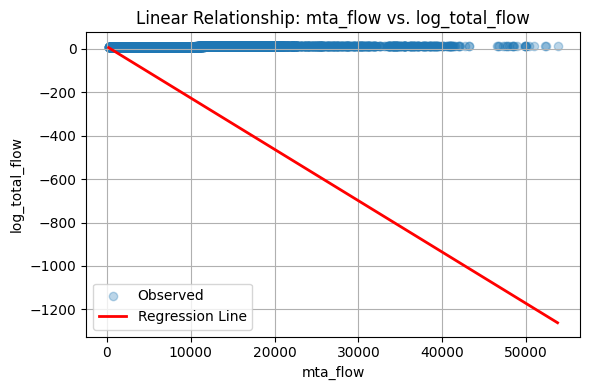


=== Plotting: taxi_flow ===


c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


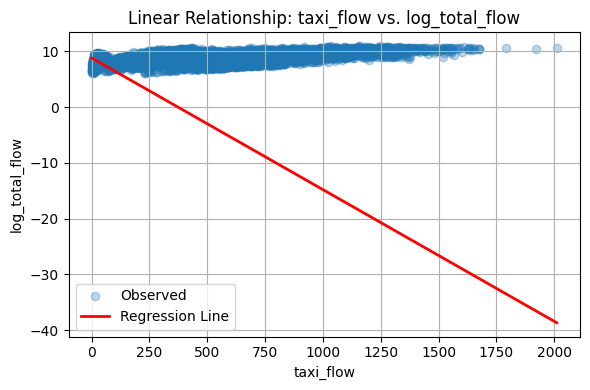


=== Plotting: fare_amount ===


c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


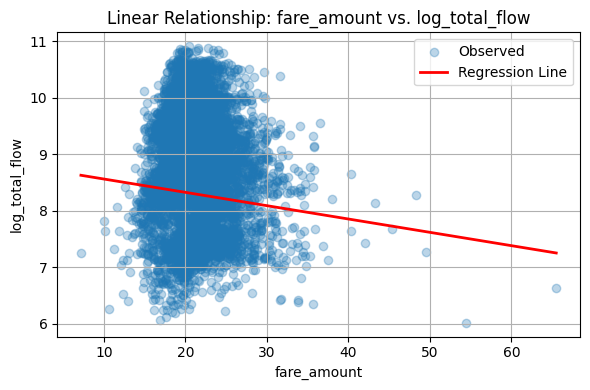


=== Plotting: has_congestion_surcharge ===


c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


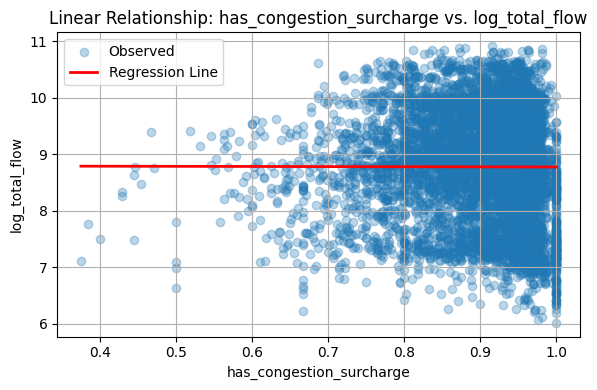

c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(



=== Plotting: temp ===


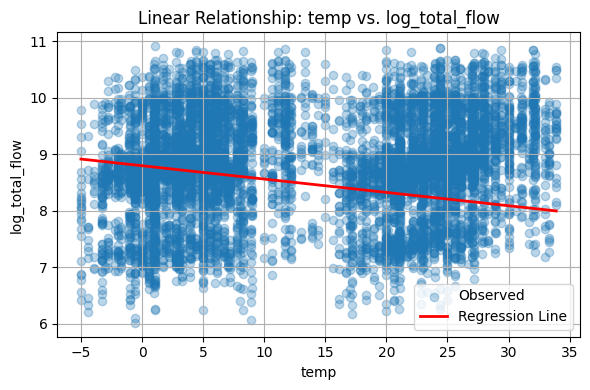


=== Plotting: prcp ===


c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


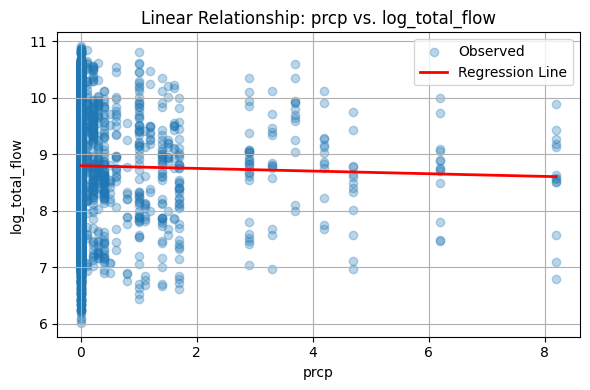

In [42]:
for feature in continuous_features:
    print(f"\n=== Plotting: {feature} ===")
    X_feature = df3[[feature]]

    x_min = X_feature[feature].min()
    x_max = X_feature[feature].max()
    x_range = np.linspace(x_min, x_max, 100).reshape(-1, 1)
    y_pred = single_features_linreg.predict(x_range)


    plt.figure(figsize=(6, 4))
    plt.scatter(X_feature, y, alpha=0.3, label='Observed')
    plt.plot(x_range, y_pred, color='red', linewidth=2, label='Regression Line')

    plt.xlabel(feature)
    plt.ylabel('log_total_flow')
    plt.title(f"Linear Relationship: {feature} vs. log_total_flow")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [43]:
#呈現負相關因為y取的是log 資料，check if mta_flow也取log

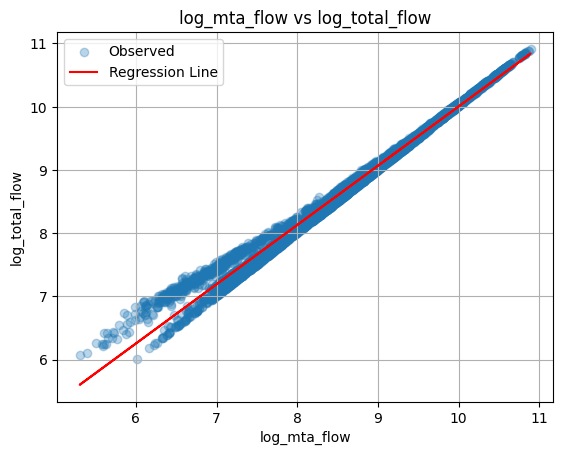

In [44]:
# Log transformation
df3['log_mta_flow'] = np.log1p(df3['mta_flow'])
df3['log_total_flow'] = np.log1p(df3['total_flow'])

# Linear Regression
from sklearn.linear_model import LinearRegression
X = df3[['log_mta_flow']]
y = df3['log_total_flow']
model = LinearRegression().fit(X, y)

# Plot
plt.scatter(X, y, alpha=0.3, label='Observed')
plt.plot(X, model.predict(X), color='red', label='Regression Line')
plt.title("log_mta_flow vs log_total_flow")
plt.xlabel("log_mta_flow")
plt.ylabel("log_total_flow")
plt.legend()
plt.grid(True)
plt.show()

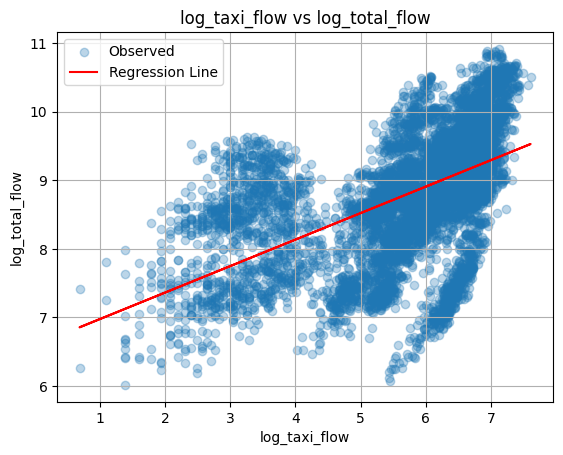

In [45]:
# Log transformation
df3['log_taxi_flow'] = np.log1p(df3['taxi_flow'])
df3['log_total_flow'] = np.log1p(df3['total_flow'])

# Linear Regression
from sklearn.linear_model import LinearRegression
X = df3[['log_taxi_flow']]
y = df3['log_total_flow']
model = LinearRegression().fit(X, y)

# Plot
plt.scatter(X, y, alpha=0.3, label='Observed')
plt.plot(X, model.predict(X), color='red', label='Regression Line')
plt.title("log_taxi_flow vs log_total_flow")
plt.xlabel("log_taxi_flow")
plt.ylabel("log_total_flow")
plt.legend()
plt.grid(True)
plt.show()

<mark>Analysis</mark>
1. log_mta_flow
- Tight linear, main variable for prediction

2. log_taxi_flow
- Though slightly postively, scatter is clearly discrete, with almost no linear relationship


3. fare_amount
- weak negative

4. has_congestion_surcharge
- neearly no linear relationship
- could consider for exclusion

5. temp
- high temp has negative influence to flow, but weak

6. prcp
- weak negative, but exist influence

`fare_amount, prcp, temp` could remain and do multiple regression

##### 2-1-2 multiple linear regression

- log_mta_flow
- log_taxi_flow
- fare_amount
- temp
- prcp
- log_total_flow

In [46]:
train_df_1 = df3[df3['month'].isin([2,6])]

print("Train size: ", len(train_df_1))
print("Test size: ", len(test_df))

Train size:  7670
Test size:  7930


In [47]:
train_df = train_df.copy()
test_df = test_df.copy()

# 再做 log transform
for df in [train_df, test_df]:
    df['log_total_flow'] = np.log1p(df['total_flow'])
    df['log_mta_flow'] = np.log1p(df['mta_flow'])
    df['log_taxi_flow'] = np.log1p(df['taxi_flow'])

In [48]:
continuous_features = [
    'log_mta_flow',
    'log_taxi_flow',
    'fare_amount',
    'has_congestion_surcharge',
    'temp',
    'prcp'
]

### 2. Advanced (Base + POI + Google Trends + events)

In [164]:
df_poi = pd.read_csv('cleaned_pois.csv')

In [165]:
df_poi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3307 entries, 0 to 3306
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   location_name    3307 non-null   object 
 1   id               3307 non-null   int64  
 2   type             3307 non-null   object 
 3   lat              3307 non-null   float64
 4   lon              3307 non-null   float64
 5   name             3307 non-null   object 
 6   amenity          1910 non-null   object 
 7   tourism          501 non-null    object 
 8   leisure          4 non-null      object 
 9   shop             937 non-null    object 
 10  category         3307 non-null   object 
 11  is_tourist_spot  3307 non-null   int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 310.2+ KB


In [167]:
zone_map_df = pd.read_csv("zone_id_name_latlon_mapping.csv")

name_to_zone = dict(zip(zone_map_df['zone_name'], zone_map_df['zone_id']))

df_poi['zone_id'] = df_poi['location_name'].map(name_to_zone)

In [129]:
zone_map_df

,zone_id,zone_name,lat,lon
0,0,Times Square,40.7580,-73.9855
1,1,Central Park,40.7678,-73.9718
2,2,Empire State Building,40.7484,-73.9857
3,3,Brooklyn Bridge,40.7061,-73.9969
4,4,Statue of Liberty Ferry,40.7033,-74.0170
5,5,Rockefeller Center,40.7587,-73.9787
6,6,One World Trade Center,40.7127,-74.0134
7,7,Metropolitan Museum of Art,40.7794,-73.9632
8,8,Grand Central Terminal,40.7527,-73.9772
9,9,MoMA,40.7614,-73.9776


In [168]:
# spot amount
tourist_count = df_poi.groupby('zone_id')['is_tourist_spot'].sum().reset_index()
tourist_count.rename(columns={'is_tourist_spot': 'zone_tourist_count'}, inplace=True)

df_poi = df_poi.merge(tourist_count, on='zone_id', how='left')
df_poi.rename(columns={'location_name': 'nearby_location_name'}, inplace=True)


In [160]:
df_poi.head()

,location_name,id,type,lat,lon,name,amenity,tourism,leisure,shop,category,is_tourist_spot,zone_id
0,Times Square,357621676,node,40.761111,-73.988333,Public School 212,school,NaN,NaN,NaN,school,0,0
1,Times Square,357648621,node,40.761511,-73.988638,M408 Professional Performing Arts High School,school,NaN,NaN,NaN,school,0,0
2,Times Square,368051619,node,40.758900,-73.984617,Palace Theater,theatre,NaN,NaN,NaN,theatre,0,0
3,Times Square,368051660,node,40.758198,-73.989556,Second Stage Theater,theatre,NaN,NaN,NaN,theatre,0,0
4,Times Square,368061366,node,40.759334,-73.984124,Times Square Museum & Visitor Center,NaN,information,NaN,NaN,information,0,0


In [169]:
df_poi.drop(columns=['id','type','name', 'amenity', 'tourism', 'leisure', 'shop'], inplace=True)

In [170]:
df_poi.tail()

,nearby_location_name,lat,lon,category,is_tourist_spot,zone_id,zone_tourist_count
3302,The High Line,40.751182,-74.003684,stripclub,0,12,4
3303,The High Line,40.747431,-73.998991,place_of_worship,0,12,4
3304,The High Line,40.747807,-73.999128,place_of_worship,0,12,4
3305,The High Line,40.748943,-74.000242,school,0,12,4
3306,The High Line,40.747125,-74.000151,place_of_worship,0,12,4


In [171]:
# 1. 計算每個 zone 的總 POI 數與旅遊點數量
zone_stats = (
    df_poi.groupby('zone_id')
    .agg(
        total_poi=('is_tourist_spot', 'count'),
        zone_tourist_count=('is_tourist_spot', 'sum')
    )
    .reset_index()
)

# 2. 計算旅遊點比例
zone_stats['tourist_ratio'] = zone_stats['zone_tourist_count'] / zone_stats['total_poi']

In [172]:
df_poi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3307 entries, 0 to 3306
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nearby_location_name  3307 non-null   object 
 1   lat                   3307 non-null   float64
 2   lon                   3307 non-null   float64
 3   category              3307 non-null   object 
 4   is_tourist_spot       3307 non-null   int64  
 5   zone_id               3307 non-null   int64  
 6   zone_tourist_count    3307 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 181.0+ KB


In [173]:
df_poi.head(10)

,nearby_location_name,lat,lon,category,is_tourist_spot,zone_id,zone_tourist_count
0,Times Square,40.761111,-73.988333,school,0,0,23
1,Times Square,40.761511,-73.988638,school,0,0,23
2,Times Square,40.758900,-73.984617,theatre,0,0,23
3,Times Square,40.758198,-73.989556,theatre,0,0,23
4,Times Square,40.759334,-73.984124,information,0,0,23
5,Times Square,40.756994,-73.986551,restaurant,0,0,23
6,Times Square,40.755908,-73.983022,bank,0,0,23
7,Times Square,40.758215,-73.986627,restaurant,0,0,23
8,Times Square,40.761717,-73.986292,supermarket,0,0,23
9,Times Square,40.759012,-73.984484,hotel,0,0,23


In [174]:
category_top = (
    df_poi.groupby(['zone_id', 'category'])
    .size()
    .reset_index(name='count')
    .sort_values(['zone_id', 'count'], ascending=[True, False])
    .drop_duplicates('zone_id')
    .rename(columns={'category': 'category_top'})
    [['zone_id', 'category_top']]
)

In [175]:
poi_summary = zone_stats.merge(category_top, on='zone_id', how='left')

In [180]:
poi_summary.head(20)

,zone_id,total_poi,zone_tourist_count,tourist_ratio,category_top
0,0,672,23,0.034226,restaurant
1,1,139,31,0.223022,clothes
2,2,683,6,0.008785,restaurant
3,3,62,6,0.096774,restaurant
4,4,142,16,0.112676,fast_food
5,5,291,10,0.034364,restaurant
6,6,304,16,0.052632,restaurant
7,7,89,9,0.101124,clothes
8,8,418,8,0.019139,fast_food
9,9,198,1,0.005051,restaurant


In [181]:
df_poi_2 = poi_summary.copy()

In [58]:
df_trd = pd.read_csv('google_trends_2024_4_months.csv')

In [59]:
df_trd.head()

,date,keyword,interest
0,2024-02-01,Times Square,62
1,2024-02-02,Times Square,62
2,2024-02-03,Times Square,55
3,2024-02-04,Times Square,56
4,2024-02-05,Times Square,61


In [60]:
df_trd['keyword'].unique()

array(['Times Square', 'MoMA', 'Roosevelt Island Tram',
       'Hudson River Kayaking', 'The High Line', 'Central Park',
       'Empire State Building', 'Brooklyn Bridge',
       'Statue of Liberty Ferry', 'Rockefeller Center',
       'One World Trade Center', 'Metropolitan Museum of Art',
       'Grand Central Terminal'], dtype=object)

In [61]:
hours = list(range(9, 19))


df_trd_expanded = df_trd.loc[df_trd.index.repeat(len(hours))].copy()

df_trd_expanded['hour'] = hours * len(df_trd)


df_trd_expanded['datetime'] = pd.to_datetime(
    df_trd_expanded['date'].astype(str) + ' ' + df_trd_expanded['hour'].astype(str) + ':00:00'
)

df_trd_expanded = df_trd_expanded[['datetime', 'date', 'hour', 'keyword', 'interest']]

In [62]:
df_trd_expanded['keyword'].unique()

array(['Times Square', 'MoMA', 'Roosevelt Island Tram',
       'Hudson River Kayaking', 'The High Line', 'Central Park',
       'Empire State Building', 'Brooklyn Bridge',
       'Statue of Liberty Ferry', 'Rockefeller Center',
       'One World Trade Center', 'Metropolitan Museum of Art',
       'Grand Central Terminal'], dtype=object)

In [63]:
df_trd_expanded

,datetime,date,hour,keyword,interest
0,2024-02-01 09:00:00,2024-02-01,9,Times Square,62
0,2024-02-01 10:00:00,2024-02-01,10,Times Square,62
0,2024-02-01 11:00:00,2024-02-01,11,Times Square,62
0,2024-02-01 12:00:00,2024-02-01,12,Times Square,62
0,2024-02-01 13:00:00,2024-02-01,13,Times Square,62
...,...,...,...,...,...
1559,2024-09-30 14:00:00,2024-09-30,14,Times Square,85
1559,2024-09-30 15:00:00,2024-09-30,15,Times Square,85
1559,2024-09-30 16:00:00,2024-09-30,16,Times Square,85
1559,2024-09-30 17:00:00,2024-09-30,17,Times Square,85


In [64]:
df_trd_expanded = df_trd_expanded.merge(
    zone_map_df[['zone_name', 'zone_id']],
    left_on='keyword',
    right_on='zone_name',
    how='left'
).drop(columns=['zone_name'])

In [65]:
print(df_trd_expanded['zone_id'].isna().sum())   # 應為 0
print(df_trd_expanded[['keyword', 'zone_id']].drop_duplicates())

0
                         keyword  zone_id
0                   Times Square        0
290                         MoMA        9
580        Roosevelt Island Tram       10
870        Hudson River Kayaking       11
1160               The High Line       12
1450                Central Park        1
1740       Empire State Building        2
2030             Brooklyn Bridge        3
2320     Statue of Liberty Ferry        4
2610          Rockefeller Center        5
2900      One World Trade Center        6
3190  Metropolitan Museum of Art        7
3480      Grand Central Terminal        8


In [66]:
#make sure expanding works for every hour and no missing
df_trd_expanded.duplicated(subset=['datetime', 'keyword']).sum()

np.int64(0)

In [67]:
df_trd_expanded.groupby(['date', 'keyword'])['interest'].nunique()

date        keyword                
2024-02-01  Brooklyn Bridge            1
            Central Park               1
            Empire State Building      1
            Grand Central Terminal     1
            Hudson River Kayaking      1
                                      ..
2024-12-31  Rockefeller Center         1
            Roosevelt Island Tram      1
            Statue of Liberty Ferry    1
            The High Line              1
            Times Square               1
Name: interest, Length: 1560, dtype: int64

In [68]:
df_ev = pd.read_csv('cleaned_event_2024.csv').drop(columns=['Unnamed: 0', 'start_dt','date'])

In [69]:
df_ev.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67156 entries, 0 to 67155
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   month                  67156 non-null  int64 
 1   day                    67156 non-null  int64 
 2   event_landmark         67156 non-null  object
 3   event_type_grouped     67156 non-null  object
 4   is_holiday             67156 non-null  bool  
 5   market                 67156 non-null  int64 
 6   other                  67156 non-null  int64 
 7   production             67156 non-null  int64 
 8   public_event           67156 non-null  int64 
 9   special                67156 non-null  int64 
 10  sport                  67156 non-null  int64 
 11  market_citywide        67156 non-null  int64 
 12  other_citywide         67156 non-null  int64 
 13  production_citywide    67156 non-null  int64 
 14  public_event_citywide  67156 non-null  int64 
 15  special_citywide   

In [70]:
df_ev.tail(5)

,month,day,event_landmark,event_type_grouped,is_holiday,market,other,production,public_event,special,sport,market_citywide,other_citywide,production_citywide,public_event_citywide,special_citywide,sport_citywide,event_time
67151,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,2024-12-31 18:00:00
67152,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,2024-12-31 18:00:00
67153,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,2024-12-31 18:00:00
67154,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,2024-12-31 18:00:00
67155,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,2024-12-31 18:00:00


In [71]:
df_ev['event_time'] = pd.to_datetime(df_ev['event_time'])
df_ev = df_ev[df_ev['event_time'].dt.hour.between(9, 18)]

In [72]:
df_ev.info(5)

<class 'pandas.core.frame.DataFrame'>
Index: 38692 entries, 1423 to 67155
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   month                  38692 non-null  int64         
 1   day                    38692 non-null  int64         
 2   event_landmark         38692 non-null  object        
 3   event_type_grouped     38692 non-null  object        
 4   is_holiday             38692 non-null  bool          
 5   market                 38692 non-null  int64         
 6   other                  38692 non-null  int64         
 7   production             38692 non-null  int64         
 8   public_event           38692 non-null  int64         
 9   special                38692 non-null  int64         
 10  sport                  38692 non-null  int64         
 11  market_citywide        38692 non-null  int64         
 12  other_citywide         38692 non-null  int64         
 13  pro

In [73]:
# daily_events
daily_event_stats = (
    df_ev.groupby(['event_landmark', 'event_time'])
    .agg(
        has_event=('event_type_grouped', lambda x: 1 if len(x) > 0 else 0),
        total_event=('event_type_grouped', 'count')
    )
    .reset_index()
)

#has_event
daily_event_stats['has_event'] = 1

df_ev = df_ev.drop_duplicates(subset=['event_landmark', 'event_time'])

In [74]:
df_ev.tail(5)

,month,day,event_landmark,event_type_grouped,is_holiday,market,other,production,public_event,special,sport,market_citywide,other_citywide,production_citywide,public_event_citywide,special_citywide,sport_citywide,event_time
67094,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,2024-12-31 15:00:00
67106,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,2024-12-31 16:00:00
67131,12,31,Central Park,special,False,0,0,0,0,413,0,0,0,4,12,104,97,2024-12-31 16:00:00
67136,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,2024-12-31 17:00:00
67144,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,2024-12-31 18:00:00


In [75]:
#add has_event, event_count;
#event_type one-hot(after split data)
#historical event 歷史活動密度

recurring_event = df_ev.groupby(['month', 'day']).size().reset_index(name='recurring_event_score')

In [76]:
df_ev = df_ev.merge(
    recurring_event,
    on=['month', 'day'],
    how='left'
)

In [77]:
df_ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   month                  699 non-null    int64         
 1   day                    699 non-null    int64         
 2   event_landmark         699 non-null    object        
 3   event_type_grouped     699 non-null    object        
 4   is_holiday             699 non-null    bool          
 5   market                 699 non-null    int64         
 6   other                  699 non-null    int64         
 7   production             699 non-null    int64         
 8   public_event           699 non-null    int64         
 9   special                699 non-null    int64         
 10  sport                  699 non-null    int64         
 11  market_citywide        699 non-null    int64         
 12  other_citywide         699 non-null    int64         
 13  produ

In [78]:
df_ev[df_ev['event_time'].dt.minute != 0][['event_time']].head(10)

,event_time


In [79]:
df_ev['event_time'].dt.minute.value_counts()

event_time
0    699
Name: count, dtype: int64

In [80]:
df_ev['event_time'] = pd.to_datetime(df_ev['event_time'], errors='coerce')
df_ev['event_time'] = df_ev['event_time'].dt.floor('h')

In [81]:
df_ev['event_time'].dt.minute.value_counts()

event_time
0    699
Name: count, dtype: int64

In [82]:
df_ev['event_time'] = pd.to_datetime(df_ev['event_time'], errors='coerce')
df_ev = df_ev[df_ev['event_time'].notna()]  # 把 NaT 的清掉
df_ev['event_time'] = df_ev['event_time'].dt.floor('H')

C:\Users\mm921\AppData\Local\Temp\ipykernel_17232\4063018494.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_ev['event_time'] = df_ev['event_time'].dt.floor('H')


In [83]:
print(df_ev['event_time'].dtype)

datetime64[ns]


In [84]:
df_ev['event_time'].dt.minute.value_counts()

event_time
0    699
Name: count, dtype: int64

In [85]:
all_cols = df_ev.columns.tolist()

In [86]:
# 1. 找出非 Central Park 的活動時間
broad_events = df_ev[df_ev['event_landmark'] != 'Central Park']['event_time'].unique()

# 2. 建立所有 zone_id 的組合
all_zone_ids = zone_map_df['zone_id'].unique()
from itertools import product
full_event_rows = pd.DataFrame(product(all_zone_ids, broad_events), columns=['zone_id', 'event_time'])

# 3. 將這些時間點 merge 回 df_ev 相關欄位（只複製 event 的分類與分數等欄）
# 假設你取的是 event_score 類欄位
all_ev = df_ev[df_ev['event_landmark'] != 'Central Park'][all_cols].drop_duplicates(subset=['event_time'])

# 4. merge event attributes
df_ev = pd.merge(full_event_rows, all_ev, on='event_time', how='left')

In [87]:
len(df_ev)

6357

In [88]:
df_ev.tail(10)

,zone_id,event_time,month,day,event_landmark,event_type_grouped,is_holiday,market,other,production,public_event,special,sport,market_citywide,other_citywide,production_citywide,public_event_citywide,special_citywide,sport_citywide,recurring_event_score
6347,12,2024-12-30 18:00:00,12,30,Other,sport,False,0,0,0,18,104,84,0,0,0,18,104,84,16
6348,12,2024-12-31 09:00:00,12,31,Other,public_event,False,0,0,4,12,104,97,0,0,4,12,104,97,14
6349,12,2024-12-31 10:00:00,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,14
6350,12,2024-12-31 11:00:00,12,31,Other,special,False,0,0,4,12,104,97,0,0,4,12,104,97,14
6351,12,2024-12-31 12:00:00,12,31,Other,special,False,0,0,4,12,104,97,0,0,4,12,104,97,14
6352,12,2024-12-31 13:00:00,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,14
6353,12,2024-12-31 15:00:00,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,14
6354,12,2024-12-31 16:00:00,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,14
6355,12,2024-12-31 17:00:00,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,14
6356,12,2024-12-31 18:00:00,12,31,Other,sport,False,0,0,4,12,104,97,0,0,4,12,104,97,14


In [89]:
df_ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6357 entries, 0 to 6356
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   zone_id                6357 non-null   int64         
 1   event_time             6357 non-null   datetime64[ns]
 2   month                  6357 non-null   int64         
 3   day                    6357 non-null   int64         
 4   event_landmark         6357 non-null   object        
 5   event_type_grouped     6357 non-null   object        
 6   is_holiday             6357 non-null   bool          
 7   market                 6357 non-null   int64         
 8   other                  6357 non-null   int64         
 9   production             6357 non-null   int64         
 10  public_event           6357 non-null   int64         
 11  special                6357 non-null   int64         
 12  sport                  6357 non-null   int64         
 13  mar

In [90]:
#combined three dataset
# df_final = merge_all_features(df_trd, df_ev, df_poi)

In [91]:
zone_map_df

,zone_id,zone_name,lat,lon
0,0,Times Square,40.7580,-73.9855
1,1,Central Park,40.7678,-73.9718
2,2,Empire State Building,40.7484,-73.9857
3,3,Brooklyn Bridge,40.7061,-73.9969
4,4,Statue of Liberty Ferry,40.7033,-74.0170
5,5,Rockefeller Center,40.7587,-73.9787
6,6,One World Trade Center,40.7127,-74.0134
7,7,Metropolitan Museum of Art,40.7794,-73.9632
8,8,Grand Central Terminal,40.7527,-73.9772
9,9,MoMA,40.7614,-73.9776


In [92]:
df_trd_expanded

,datetime,date,hour,keyword,interest,zone_id
0,2024-02-01 09:00:00,2024-02-01,9,Times Square,62,0
1,2024-02-01 10:00:00,2024-02-01,10,Times Square,62,0
2,2024-02-01 11:00:00,2024-02-01,11,Times Square,62,0
3,2024-02-01 12:00:00,2024-02-01,12,Times Square,62,0
4,2024-02-01 13:00:00,2024-02-01,13,Times Square,62,0
...,...,...,...,...,...,...
15595,2024-09-30 14:00:00,2024-09-30,14,Times Square,85,0
15596,2024-09-30 15:00:00,2024-09-30,15,Times Square,85,0
15597,2024-09-30 16:00:00,2024-09-30,16,Times Square,85,0
15598,2024-09-30 17:00:00,2024-09-30,17,Times Square,85,0


In [93]:
df_trd_expanded.head()

,datetime,date,hour,keyword,interest,zone_id
0,2024-02-01 09:00:00,2024-02-01,9,Times Square,62,0
1,2024-02-01 10:00:00,2024-02-01,10,Times Square,62,0
2,2024-02-01 11:00:00,2024-02-01,11,Times Square,62,0
3,2024-02-01 12:00:00,2024-02-01,12,Times Square,62,0
4,2024-02-01 13:00:00,2024-02-01,13,Times Square,62,0


In [182]:
# Step 1. 主表 df_trd_expanded
df_final = df_trd_expanded.copy()

# Step 2a. 製作 has_event 標記表（活動出現記錄）
has_event_summary = df_ev[['zone_id', 'event_time']].drop_duplicates().copy()
has_event_summary = has_event_summary.rename(columns={'event_time': 'datetime'})
has_event_summary['has_event'] = 1

# Step 2b. 活動類型每日統計（非必要，但可以補充用）
event_summary = (
    df_ev.groupby('event_time')
    .agg(
        total_event=('event_type_grouped', 'count'),
        event_types=('event_type_grouped', lambda x: sorted(set(x)))
    )
    .reset_index()
)

# Step 3. 合併活動資料（包含各類活動欄位）
df_final = df_final.merge(
    df_ev,
    how='left',
    left_on=['zone_id', 'datetime'],
    right_on=['zone_id', 'event_time']
)

# Step 4. 合併 has_event 標記資料，補 0
df_final = df_final.merge(
    has_event_summary,
    on=['zone_id', 'datetime'],
    how='left'
)
df_final['has_event'] = df_final['has_event'].fillna(0)

# Step 4.5 合併每日總事件統計（含 total_event）
event_summary = event_summary.rename(columns={'event_time': 'datetime'})
df_final = df_final.merge(event_summary[['datetime', 'total_event']], on='datetime', how='left')


# Step 5. 填補 NaN 的活動欄位（排除 has_event 因為已補）
event_cols = [
    'market', 'production', 'other', 'public_event', 'special', 'sport',
    'market_citywide', 'other_citywide', 'production_citywide',
    'public_event_citywide', 'special_citywide', 'sport_citywide',
    'event_type_grouped', 'event_landmark', 'is_holiday',
    'recurring_event_score', 'total_event'
]

for col in event_cols:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna(0)

# Step 6. 加入 POI 資訊

df_final = df_final.merge(
    poi_summary[['zone_id', 'zone_tourist_count', 'tourist_ratio', 'category_top']],
    on='zone_id',
    how='left'
)
# Step 7. 儲存結果
# df_final.to_csv("final_data_combined.csv", index=False)


In [183]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15600 entries, 0 to 15599
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   datetime               15600 non-null  datetime64[ns]
 1   date                   15600 non-null  object        
 2   hour                   15600 non-null  int64         
 3   keyword                15600 non-null  object        
 4   interest               15600 non-null  int64         
 5   zone_id                15600 non-null  int64         
 6   event_time             6357 non-null   datetime64[ns]
 7   month                  6357 non-null   float64       
 8   day                    6357 non-null   float64       
 9   event_landmark         15600 non-null  object        
 10  event_type_grouped     15600 non-null  object        
 11  is_holiday             15600 non-null  object        
 12  market                 15600 non-null  float64       
 13  o

In [96]:
# #old
# df_trd['date'] = pd.to_datetime(df_trd['date']).dt.date
# df_ev['event_time'] = pd.to_datetime(df_ev['event_time'])
# df_ev['date'] = df_ev['event_time'].dt.date

# # 1. df_trd use keyword mapping add zone_id
# # df_trd_mapped = df_trd.merge(zone_map_df, left_on='keyword', right_on='nearby_location_name', how='left')
# # df_trd_mapped['date'] = pd.to_datetime(df_trd_mapped['date'])
# df_trd['zone_id'] = df_trd['keyword'].map(name_to_zone)


# # 2. df_ev groupby date sum event_type --> 拆資料集在處理
# # event_ohe = pd.get_dummies(df_ev['event_type_grouped'])
# # event_type_daily = pd.concat([df_ev['date'], event_ohe], axis=1).groupby('date').sum().reset_index()
# # event_summary = (
# #     df_ev.groupby('date')
# #     .agg(
# #         event_count=('event_type_grouped', 'count'),
# #         event_types=('event_type_grouped', lambda x: sorted(set(x)))
# #     )
# #     .reset_index()
# # )
# # event_summary['has_event'] = 1

# # 3.
# df_final = (
#     df_trd
#     # .merge(df_ev, on='date', how='left')  # 對時間做 join
#     .merge(df_ev, on=['zone_id', 'date'], how='left')
#     .merge(daily_event_stats, on=['event_time', 'event_landmark'], how='left')  # 精準對活動
#     .merge(df_poi[['zone_id', 'zone_tourist_count']].drop_duplicates(), on='zone_id', how='left')  # 對 zone 加上旅遊人氣
# )

In [184]:
#missing data
activity_cols = ['event_landmark', 'event_type_grouped', 'is_holiday',
                'market', 'other', 'production', 'public_event', 'special', 'sport',
                'market_citywide', 'other_citywide', 'production_citywide', 'public_event_citywide',
                'special_citywide', 'sport_citywide', 'event_time', 'recurring_event_score',
                'has_event', 'total_event']

df_final[activity_cols] = df_final[activity_cols].fillna(0)

In [185]:
df_final['month'] = df_final['month'].astype(float)
df_final['day'] = df_final['day'].astype(float)

df_final['date'] = pd.to_datetime(df_final['date'], errors='coerce')

df_final['month'] = df_final['date'].apply(lambda x: x.month if pd.notnull(x) else np.nan)
df_final['day'] = df_final['date'].apply(lambda x: x.day if pd.notnull(x) else np.nan)

In [186]:
df_final['month'] = df_final['month'].astype('Int64')
df_final['day'] = df_final['day'].astype('Int64')

In [187]:
df_final = df_final.drop(columns=['date'])

In [188]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15600 entries, 0 to 15599
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   datetime               15600 non-null  datetime64[ns]
 1   hour                   15600 non-null  int64         
 2   keyword                15600 non-null  object        
 3   interest               15600 non-null  int64         
 4   zone_id                15600 non-null  int64         
 5   event_time             15600 non-null  object        
 6   month                  15600 non-null  Int64         
 7   day                    15600 non-null  Int64         
 8   event_landmark         15600 non-null  object        
 9   event_type_grouped     15600 non-null  object        
 10  is_holiday             15600 non-null  object        
 11  market                 15600 non-null  float64       
 12  other                  15600 non-null  float64       
 13  p

In [189]:
df_final.head(10)
#TODO

,datetime,hour,keyword,interest,zone_id,event_time,month,day,event_landmark,event_type_grouped,...,production_citywide,public_event_citywide,special_citywide,sport_citywide,recurring_event_score,has_event,total_event,zone_tourist_count,tourist_ratio,category_top
0,2024-02-01 09:00:00,9,Times Square,62,0,2024-02-01 09:00:00,2,1,Other,sport,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant
1,2024-02-01 10:00:00,10,Times Square,62,0,2024-02-01 10:00:00,2,1,Other,sport,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant
2,2024-02-01 11:00:00,11,Times Square,62,0,2024-02-01 11:00:00,2,1,Other,market,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant
3,2024-02-01 12:00:00,12,Times Square,62,0,2024-02-01 12:00:00,2,1,Other,sport,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant
4,2024-02-01 13:00:00,13,Times Square,62,0,2024-02-01 13:00:00,2,1,Other,sport,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant
5,2024-02-01 14:00:00,14,Times Square,62,0,2024-02-01 14:00:00,2,1,Other,sport,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant
6,2024-02-01 15:00:00,15,Times Square,62,0,2024-02-01 15:00:00,2,1,Other,sport,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant
7,2024-02-01 16:00:00,16,Times Square,62,0,2024-02-01 16:00:00,2,1,Other,sport,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant
8,2024-02-01 17:00:00,17,Times Square,62,0,2024-02-01 17:00:00,2,1,Other,sport,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant
9,2024-02-01 18:00:00,18,Times Square,62,0,2024-02-01 18:00:00,2,1,Other,sport,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant


In [ ]:
# df_final = df_final.rename(columns={'category': 'poi_category'})

In [190]:
df_final.to_csv("add_features_df_final.csv")

explain columns
1. Time and date
    - event_time
    - date
    - month
    - day

2. Geography and location fields
    - zone_id
    - event_landmark
3. Google trends data
    - interest
4. Event
    - event_type_grouped
    - is_holiday
    - market/production/public_event/other/_citywide (events without actual zone places)
    - has_event
    - total_event 
        - total number of events under the landmark at the same time
5. others
    - recurring_event_score 
        - The number of events that have occurred on this “month/day” historically to determine if the day is a “potential event day”, even if the day is not noted as active in that year.

6. Poi
    - zone_tourist_count

### data check

In [104]:
# 找出 df_final 中有 NaN 的日期
# na_dates = df_final[df_final['month'].isna()]['date'].unique()

# 看看這些日期在 df_ev 中是否出現過
# missing_event_check = df_ev[df_ev['date'].isin(na_dates)]

# 結果
# print(f"These NaN date in df_ev counts: {len(missing_event_check)}")
# print(missing_event_check[['date', 'event_type_grouped']].drop_duplicates().sort_values('date'))

In [191]:
df_final.isna().sum().sort_values(ascending=False)

datetime                 0
hour                     0
keyword                  0
interest                 0
zone_id                  0
event_time               0
month                    0
day                      0
event_landmark           0
event_type_grouped       0
is_holiday               0
market                   0
other                    0
production               0
public_event             0
special                  0
sport                    0
market_citywide          0
other_citywide           0
production_citywide      0
public_event_citywide    0
special_citywide         0
sport_citywide           0
recurring_event_score    0
has_event                0
total_event              0
zone_tourist_count       0
tourist_ratio            0
category_top             0
dtype: int64

In [106]:
# df_final[df_final['month'].isna()]['date'].unique()

In [107]:
# na_summary = df_final[df_final.isna().any(axis=1)].groupby('date').size()
# print(na_summary)

In [192]:
df_trd['date'].min(), df_trd['date'].max()

('2024-02-01', '2024-12-31')

In [193]:
df_final

,datetime,hour,keyword,interest,zone_id,event_time,month,day,event_landmark,event_type_grouped,...,production_citywide,public_event_citywide,special_citywide,sport_citywide,recurring_event_score,has_event,total_event,zone_tourist_count,tourist_ratio,category_top
0,2024-02-01 09:00:00,9,Times Square,62,0,2024-02-01 09:00:00,2,1,Other,sport,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant
1,2024-02-01 10:00:00,10,Times Square,62,0,2024-02-01 10:00:00,2,1,Other,sport,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant
2,2024-02-01 11:00:00,11,Times Square,62,0,2024-02-01 11:00:00,2,1,Other,market,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant
3,2024-02-01 12:00:00,12,Times Square,62,0,2024-02-01 12:00:00,2,1,Other,sport,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant
4,2024-02-01 13:00:00,13,Times Square,62,0,2024-02-01 13:00:00,2,1,Other,sport,...,99.0,120.0,140.0,976.0,11.0,1.0,13.0,23,0.034226,restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15595,2024-09-30 14:00:00,14,Times Square,85,0,0,9,30,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0.034226,restaurant
15596,2024-09-30 15:00:00,15,Times Square,85,0,0,9,30,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0.034226,restaurant
15597,2024-09-30 16:00:00,16,Times Square,85,0,0,9,30,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0.034226,restaurant
15598,2024-09-30 17:00:00,17,Times Square,85,0,0,9,30,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0.034226,restaurant


In [195]:
print("df_final 中有 NaN 的欄位：")
print(df_final.isna().sum()[df_final.isna().sum() > 0])

df_final 中有 NaN 的欄位：
Series([], dtype: int64)


In [196]:
df_final['zone_id'].value_counts().sort_index()

zone_id
0     1200
1     1200
2     1200
3     1200
4     1200
5     1200
6     1200
7     1200
8     1200
9     1200
10    1200
11    1200
12    1200
Name: count, dtype: int64

In [197]:
df_final.to_csv("final_additional_data_poi_event_trends.csv")